### Unzip the original dataset

In [ ]:
!unzip test.zip

Archive:  test.zip
  inflating: test.csv                


### Imports

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import json

In [ ]:
df=pd.read_csv('test.csv')

### Action distribution on the starting dataset

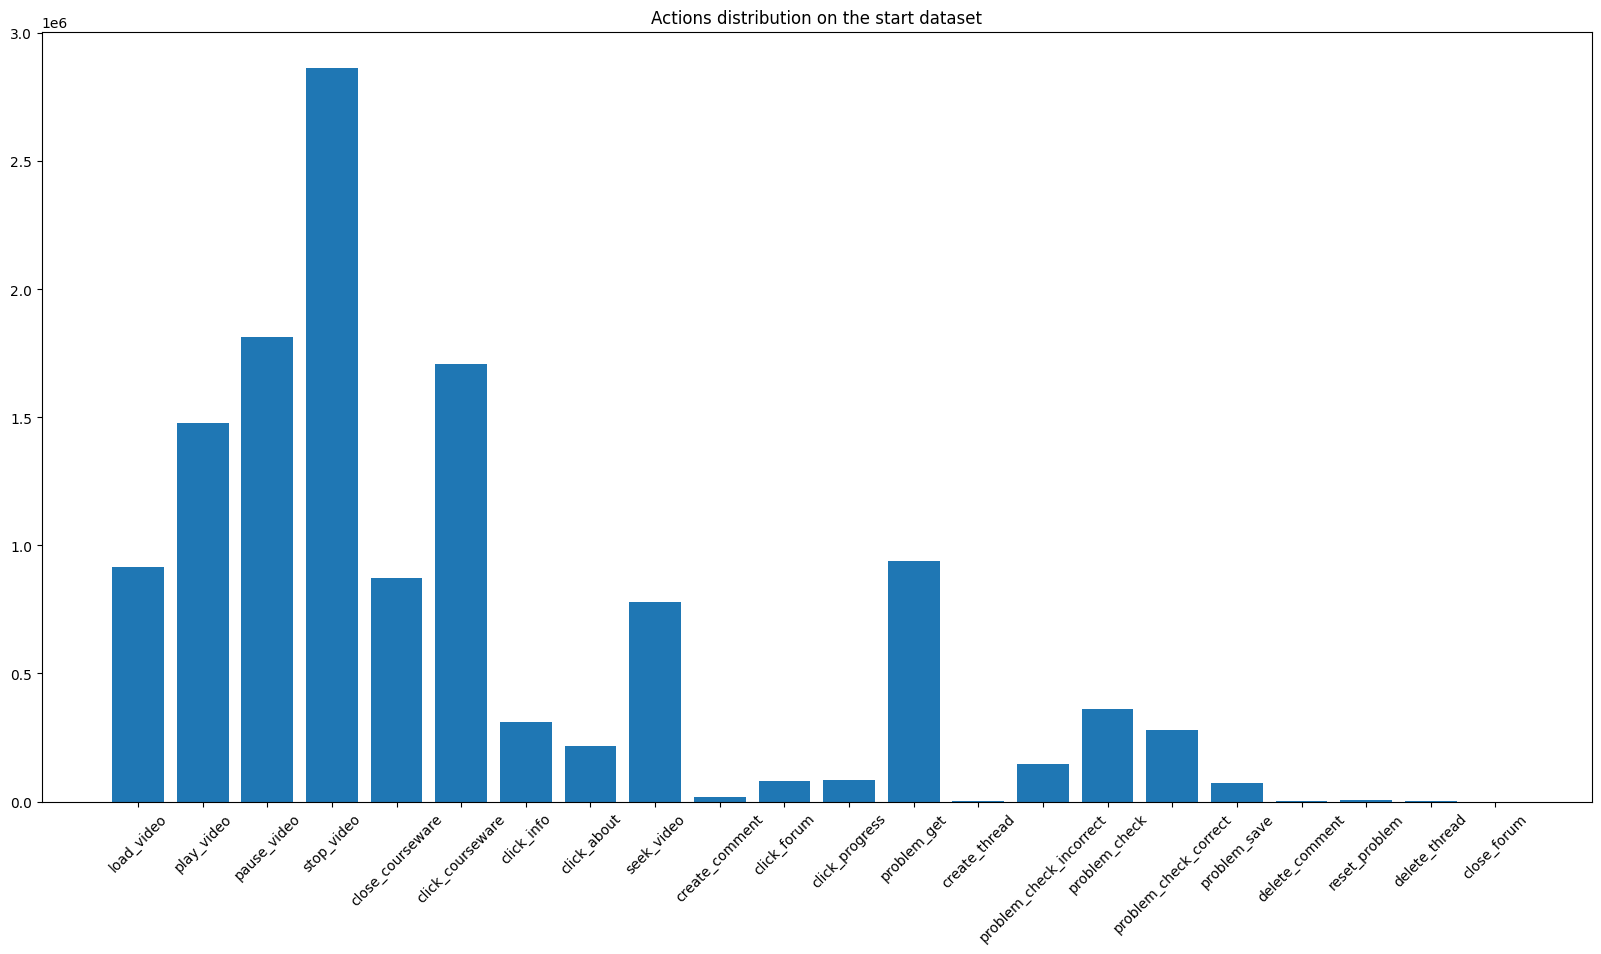

In [ ]:
actions_distribution=Counter(df['action'])

actions=list(actions_distribution.keys())
values=list(actions_distribution.values())

fig=plt.figure(figsize=(20,10))
plt.bar(actions, values)
plt.xticks(rotation=45)
plt.title('Actions distribution on the start dataset')
plt.show()

### Class distribution on the starting dataset

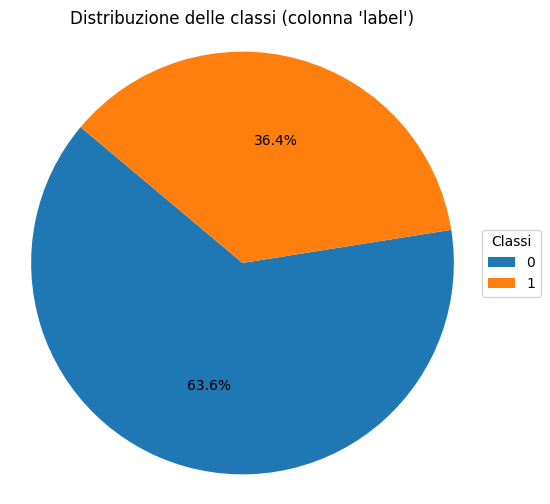

In [ ]:
class_counts = df['truth'].value_counts()

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    class_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=140
)

ax.legend(
    wedges,
    class_counts.index,
    title="Classes",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

ax.set_title("Class distribution")
ax.axis('equal')

plt.show()


### Obtaining  the triples

In [ ]:
triples=df[['username','action','course_id']]
triples=triples.drop_duplicates()

In [ ]:
triples.head()

,username,action,course_id
0,1520977,load_video,course-v1:TsinghuaX+70800232X+2015_T2
2,1520977,play_video,course-v1:TsinghuaX+70800232X+2015_T2
3,1520977,pause_video,course-v1:TsinghuaX+70800232X+2015_T2
4,1520977,stop_video,course-v1:TsinghuaX+70800232X+2015_T2
5,1520977,close_courseware,course-v1:TsinghuaX+70800232X+2015_T2


In [ ]:
#Some relation are barely present in the dataset. to have a more uniform diatribution of relationship, they were removed

c=Counter(df['action'])

for key in list(c.keys()):
  if c[key]>1000:
    del c[key]

l=list(c)

for i in l:
  triples=triples.replace(i, np.nan)

triples=triples.dropna()

### Actions distributions on triples

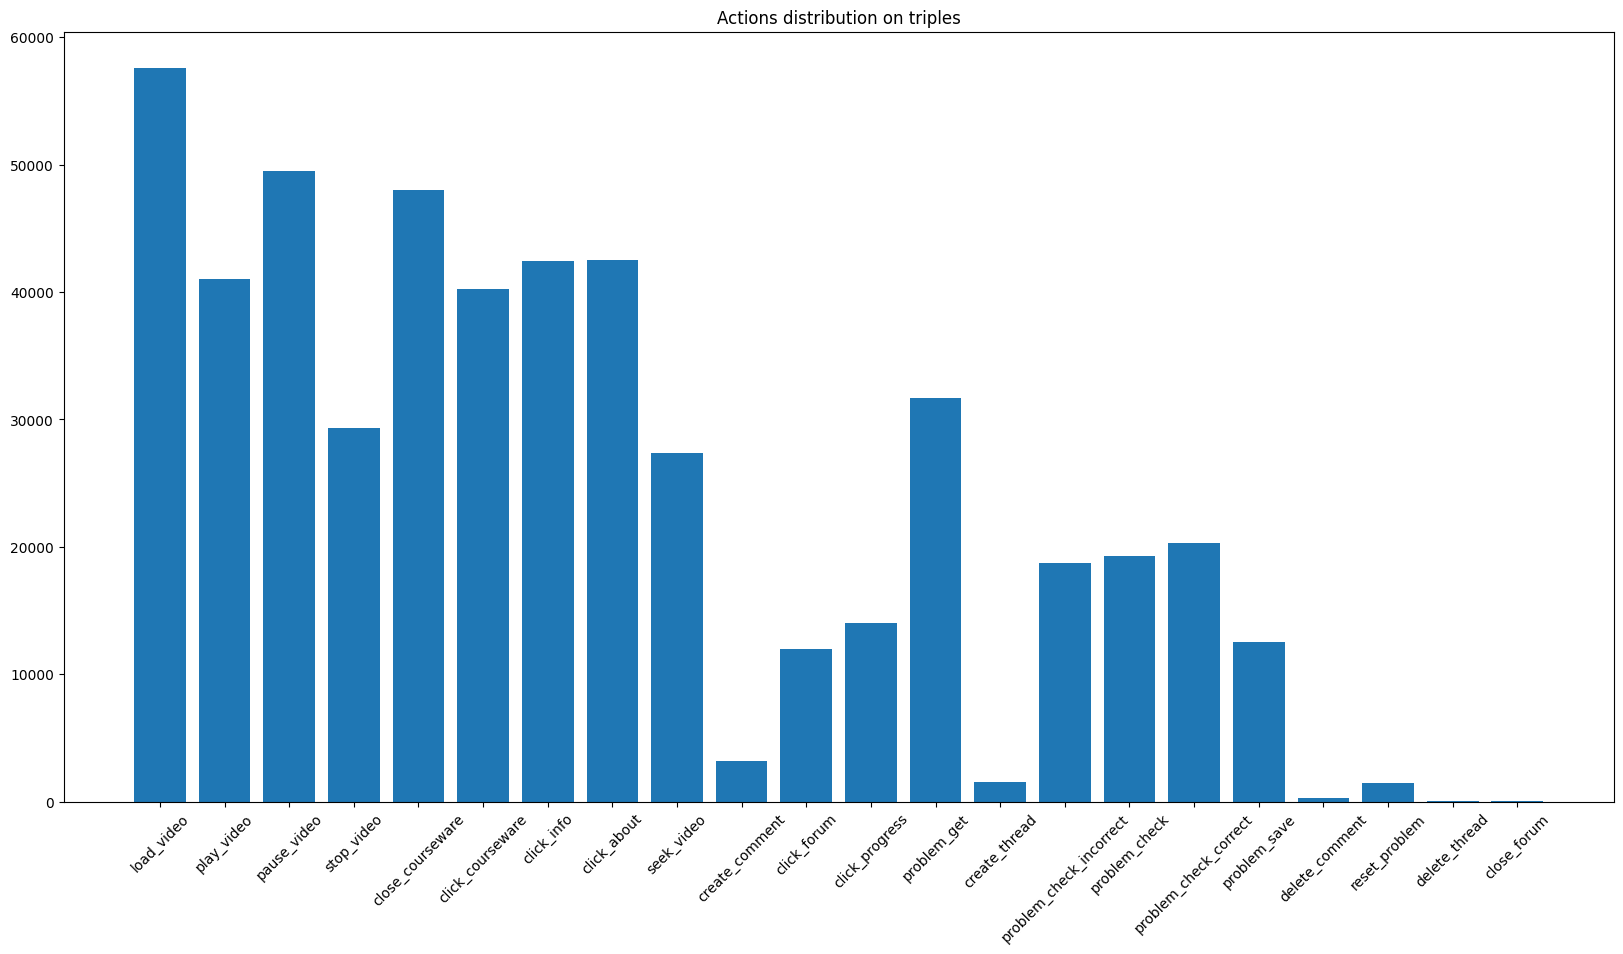

In [ ]:
actions_distribution=Counter(triples['action'])

actions=list(actions_distribution.keys())
values=list(actions_distribution.values())

fig=plt.figure(figsize=(20,10))
plt.bar(actions, values)
plt.xticks(rotation=45)
plt.title('Actions distribution on triples')
plt.show()

In [ ]:
print(f'NUMBER OF TRIPLES: {len(triples)}')
print(f'NUMBER OF USERS: {len(set(df["username"]))}')
print(f'NUMBER OF COURSES: {len(set(df["course_id"]))}')
print(f'NUMBER OF RELATIONS: {len(set(df["action"]))}')

NUMBER OF TRIPLES: 512781
NUMBER OF USERS: 44008
NUMBER OF COURSES: 247
NUMBER OF RELATIONS: 22


### Generate the dataset for classification

In [ ]:
# Assign a dummy value of 1 to every row, to be used in the pivot
df["value"] = 1

# Create a wide-format DataFrame where each row is a (username, course_id) pair,
# and each action becomes a separate column with 1 if it occurred, 0 otherwise
df_wide = (
    df
    .pivot_table(
        index=["username", "course_id"],  # group by these two keys
        columns="action",                 # each unique action becomes a new column
        values="value",                   # use the dummy value
        aggfunc="max",                    # if multiple rows, take the max (i.e., 1 if any action occurred)
        fill_value=0                      # fill missing values with 0 (i.e., action did not occur)
    )
    .reset_index()                        # move index back to columns
)

# Remove the name of the column index (created by pivot_table)
df_wide.columns.name = None

# Extract the 'truth' label for each (username, course_id) pair
# using the first value encountered in each group
labels = df.groupby(['username', 'course_id'])['truth'].first().reset_index()

df_labeled = df_wide.merge(labels, on=['username', 'course_id'], how='left')

df_labeled.head()

truth
1    51316
0    16383
Name: count, dtype: int64


,username,course_id,click_about,click_courseware,click_forum,click_info,click_progress,close_courseware,close_forum,create_comment,...,play_video,problem_check,problem_check_correct,problem_check_incorrect,problem_get,problem_save,reset_problem,seek_video,stop_video,truth
0,5,course-v1:Tsinghua+20150001+2015_T2,1,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,5,course-v1:TsinghuaX+00740123X+2016_T1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
2,5,course-v1:TsinghuaX+30240184+2015_T2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5,course-v1:UQx+Crime101x+_,1,1,0,1,0,1,0,0,...,1,1,1,1,1,0,0,0,1,1
4,7,course-v1:MITx+15_671x+2015_T2,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Class distribution on the classification dataset

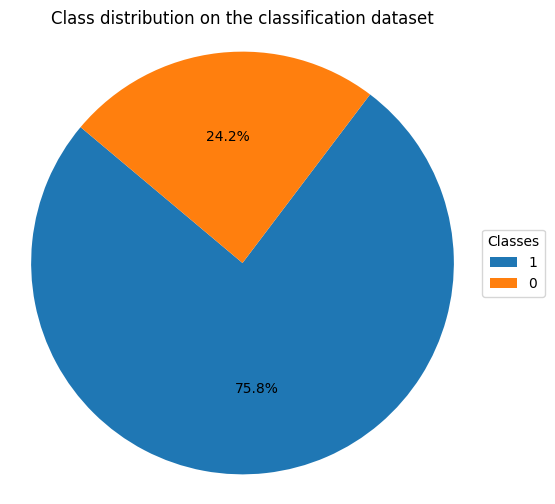

In [ ]:
class_counts = df_labeled['truth'].value_counts()

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    class_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=140
)

ax.legend(
    wedges,
    class_counts.index,
    title="Classes",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

ax.set_title("Class distribution on the classification dataset")
ax.axis('equal')

plt.show()


### Changing user and courses with ids provided by TriplesFactory!!

In [ ]:
with open('entity_to_id.json', 'r') as f:
    entities_id = json.load(f)

df_labeled['username']=df_labeled['username'].astype(str).replace(entities_id)
df_labeled['course_id']=df_labeled['course_id'].replace(entities_id)

df_labeled.head(1000)

/tmp/ipython-input-45-1938366132.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ugo['username']=ugo['username'].astype(str).replace(entities_id)
/tmp/ipython-input-45-1938366132.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ugo['course_id']=ugo['course_id'].replace(entities_id)


,username,course_id,click_about,click_courseware,click_forum,click_info,click_progress,close_courseware,create_comment,create_thread,...,play_video,problem_check,problem_check_correct,problem_check_incorrect,problem_get,problem_save,reset_problem,seek_video,stop_video,truth
0,32670,44081,1,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,32670,44126,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
2,32670,44173,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,32670,44249,1,1,0,1,0,1,0,0,...,1,1,1,1,1,0,0,0,1,1
4,40980,44062,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5158,44076,1,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
996,5158,44080,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
997,5158,44086,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
998,5158,44157,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_labeled.to_csv('classification_dataset.csv',index=False, index_label=False)